<a href="https://colab.research.google.com/github/sachinh35/CSE-519-Stony-Brook/blob/master/Code/Notebooks/LSTM_all_3/LSTM_48_hours_TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/lib

per_patient_roc.py  plotting.py  __pycache__  utils.py


In [0]:
import os
import sys 
sys.path.append(os.getcwd() + "/drive/My Drive/Colab Notebooks/lib")
from utils import connectToDB, closeConnection, save_in_pickle, load_from_pickle, cleanText 
import pandas as pd

DIR = "/content/drive/My Drive/Colab Notebooks"

In [0]:
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
import numpy as np

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [0]:
df = pd.read_csv(DIR + "/outputs/notes_within_48hrs_outtime.csv")
df.drop(columns = ['Unnamed: 0'], inplace = True)
df['charttime'] = pd.to_datetime(df['charttime'])

In [0]:
df.head()

,subject_id,text,category,chartdate,charttime,expire_flag,date_or_time
0,2,Neonatology Attending Triage Note\n\nBaby [**N...,Nursing/other,2138-07-17,2138-07-17 22:51:00,0,2138-07-17 22:51:00
1,2,Nursing Transfer note\n\n\nPt admitted to NICU...,Nursing/other,2138-07-17,2138-07-17 23:08:00,0,2138-07-17 23:08:00
2,4,[**2191-3-16**] 0500\nGeneral: Pt in to EW fro...,Nursing/other,2191-03-16,2191-03-16 05:01:00,0,2191-03-16 05:01:00
3,4,[**2191-3-16**] 12:57 PM\n CHEST (PORTABLE AP)...,Radiology,2191-03-16,2191-03-16 12:57:00,0,2191-03-16 12:57:00
4,4,nursing progress note see careview for details...,Nursing/other,2191-03-16,2191-03-16 15:27:00,0,2191-03-16 15:27:00


In [0]:
for i in range(len(df)):
  if pd.isna(df['charttime'][i]):
    df.drop(i, inplace = True)

In [0]:
df.index = range(len(df))

In [0]:
full_cleaned = [cleanText(i) for i in df['text']]

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_features = 100)
X_train_counts = count_vect.fit_transform(full_cleaned)

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(87030, 100)

In [0]:
X_train_tfidf = X_train_tfidf.toarray()

In [0]:
notes_per_patient_taken = 10

In [0]:
unique_subjectids = df['subject_id'].unique()
notes_per_subject_id = {}
notes_per_subject_id_full = {}

for i in unique_subjectids:
  temp = df[df['subject_id'] == i].tail(notes_per_patient_taken)#Taking the last 10 i.e latest 10 notes of the patient.
  temp1 = df[df['subject_id'] == i]
  
  temp_list = [X_train_tfidf[j] for j in temp.index]
  temp1_list = [X_train_tfidf[j] for j in temp1.index]
  
  notes_per_subject_id[i] = temp_list
  notes_per_subject_id_full[i] = temp1_list
  """
  now dictionary will be like this 
  notes_per_subject_id = {2 : ['first note', 'second note'.. upto 10 notes]}
  for each subject_id
  This will directly contain the vectors of each note and not the text of the notes
  """

In [0]:
import numpy as np

for i in unique_subjectids:
  if len(notes_per_subject_id[i]) < notes_per_patient_taken:
    number_of_padded_lists = notes_per_patient_taken - len(notes_per_subject_id[i])
    t = [np.zeros(100, dtype = float) for i in range(number_of_padded_lists)]
    notes_per_subject_id[i] = np.array(t + notes_per_subject_id[i])

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

#assuming all 4 columns correspond to 1 song
data_dim = 100
#so one song would be 10x4 2D array 
number_of_notes_per_patient = notes_per_patient_taken
n_notes_train = len(notes_per_subject_id)
#tunable parameter
batch_size = 50
epochs = 10

In [0]:
x_train_lstm = np.array([notes_per_subject_id[i] for i in notes_per_subject_id])
y_lstm = []
for i in unique_subjectids:
  temp = df[df['subject_id'] == i]['expire_flag']
  temp.index = range(len(temp))
  y_lstm.append(temp[0])
  
y_lstm = np.array(y_lstm)

In [0]:
print("Length of train set is",len(x_train_lstm))
print("Length of label set is",len(y_lstm))

Length of train set is 2602
Length of label set is 2602


In [0]:
model = Sequential()
model.add(LSTM(100, input_shape=(None, data_dim),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(200))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [0]:
model.fit(x_train_lstm[0:2200],y_lstm[0:2200], validation_data = (x_train_lstm[2200:],y_lstm[2200:]), batch_size=batch_size, epochs=epochs)

Train on 2200 samples, validate on 402 samples
Epoch 1/10
2200/2200 [==============================] - 3s 2ms/step - loss: 0.3774 - acc: 0.8877 - val_loss: 0.2951 - val_acc: 0.8806
Epoch 2/10
2200/2200 [==============================] - 2s 898us/step - loss: 0.2026 - acc: 0.9259 - val_loss: 0.2027 - val_acc: 0.9204
Epoch 3/10
2200/2200 [==============================] - 2s 888us/step - loss: 0.1470 - acc: 0.9436 - val_loss: 0.2045 - val_acc: 0.9204
Epoch 4/10
2200/2200 [==============================] - 2s 898us/step - loss: 0.1257 - acc: 0.9568 - val_loss: 0.1527 - val_acc: 0.9378
Epoch 5/10
2200/2200 [==============================] - 2s 890us/step - loss: 0.0994 - acc: 0.9641 - val_loss: 0.1073 - val_acc: 0.9527
Epoch 6/10
2200/2200 [==============================] - 2s 878us/step - loss: 0.0844 - acc: 0.9677 - val_loss: 0.1649 - val_acc: 0.9353
Epoch 7/10
2200/2200 [==============================] - 2s 872us/step - loss: 0.0832 - acc: 0.9655 - val_loss: 0.0930 - val_acc: 0.9627
Epo

In [0]:
all_notevectors = [notes_per_subject_id_full[i] for i in notes_per_subject_id_full]
all_notevectors = [j for i in all_notevectors for j in i]

In [0]:
prediction_array = []
k = 0

for i in unique_subjectids:
  print("Now processing ", k, "subject id out of ", len(unique_subjectids))  
  t = df[df['subject_id'] == i]
  if len(t) == 1:
    idx = t.index[0]
    preds = model.predict_proba([[[all_notevectors[idx]]]])
    prediction_array.append(preds)
  else:
    first_idx = t.index[0]
    for j in t.index[1:]:
      preds = model.predict_proba([[all_notevectors[first_idx : j]]])
      prediction_array.append(preds)
    last_idx = t.index[-1] + 1
    preds = model.predict_proba([[all_notevectors[first_idx : last_idx]]])
    prediction_array.append(preds)
    
  k += 1

Now processing  0 subject id out of  2602
Now processing  1 subject id out of  2602
Now processing  2 subject id out of  2602
Now processing  3 subject id out of  2602
Now processing  4 subject id out of  2602
Now processing  5 subject id out of  2602
Now processing  6 subject id out of  2602
Now processing  7 subject id out of  2602
Now processing  8 subject id out of  2602
Now processing  9 subject id out of  2602
Now processing  10 subject id out of  2602
Now processing  11 subject id out of  2602
Now processing  12 subject id out of  2602
Now processing  13 subject id out of  2602
Now processing  14 subject id out of  2602
Now processing  15 subject id out of  2602
Now processing  16 subject id out of  2602
Now processing  17 subject id out of  2602
Now processing  18 subject id out of  2602
Now processing  19 subject id out of  2602
Now processing  20 subject id out of  2602
Now processing  21 subject id out of  2602
Now processing  22 subject id out of  2602
Now processing  23 su

In [0]:
save_in_pickle(prediction_array, "predictionarray_lstm_48hrs_tfidf.pickle")

In [0]:
prediction_array = [prediction_array[i][0][0] for i in range(len(prediction_array))]

In [0]:
prediction_array[0]

0.15367906

In [0]:
df = df.assign(scores = prediction_array)

In [0]:
df.head()

,subject_id,text,category,chartdate,charttime,expire_flag,date_or_time,scores
0,2,Neonatology Attending Triage Note\n\nBaby [**N...,Nursing/other,2138-07-17,2138-07-17 22:51:00,0,2138-07-17 22:51:00,0.153679
1,2,Nursing Transfer note\n\n\nPt admitted to NICU...,Nursing/other,2138-07-17,2138-07-17 23:08:00,0,2138-07-17 23:08:00,0.009348
2,4,[**2191-3-16**] 0500\nGeneral: Pt in to EW fro...,Nursing/other,2191-03-16,2191-03-16 05:01:00,0,2191-03-16 05:01:00,0.457187
3,4,[**2191-3-16**] 12:57 PM\n CHEST (PORTABLE AP)...,Radiology,2191-03-16,2191-03-16 12:57:00,0,2191-03-16 12:57:00,0.301471
4,4,nursing progress note see careview for details...,Nursing/other,2191-03-16,2191-03-16 15:27:00,0,2191-03-16 15:27:00,0.222981


In [0]:
#test_dict = {3:{'score':[], 'time':[]}}
df['charttime'] = pd.to_datetime(df['charttime'])

test_dict = {}
for i in range(len(df)):
  if df['subject_id'][i] not in test_dict:
    #test_dict[3].append((df['scores'][i],df['chartdate'][i]))
    test_dict[df['subject_id'][i]] = {'score':[], 'time':[]}
    test_dict[df['subject_id'][i]]['score'].append(df['scores'][i])
    test_dict[df['subject_id'][i]]['time'].append(df['charttime'][i])
  elif df['subject_id'][i] in test_dict:
    test_dict[df['subject_id'][i]]['score'].append(df['scores'][i])
    test_dict[df['subject_id'][i]]['time'].append(df['charttime'][i])

In [0]:
conn, curr = connectToDB()
curr.execute("SELECT subject_id,dod FROM mimiciii.patients order by subject_id limit 200000")
query = curr.fetchall()


patient_dict = {}
for i in query:
  if i[1] is not None:
    patient_dict[i[0]] = pd.to_datetime(i[1])

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


	 before all other events in their time series


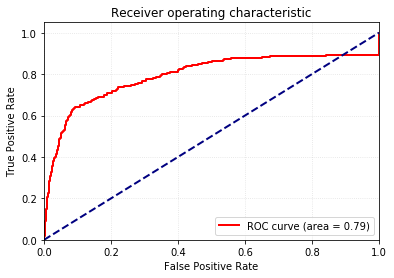

In [0]:
import per_patient_roc as ppr

new_obj = ppr.PerPatientROC()
new_obj.process_patient_scores(test_dict, patient_dict)
new_obj.draw_roc()

In [0]:
new_obj.get_event_stats_at_specificity(test_dict, patient_dict, 0.67, 'death')

1535 2291
0.6700130947184636
Median detection time  81.1
Percent detection before death event  77.81350482315112


In [0]:
new_obj.get_tpr_at_specificity(0.67)

0.3330423395896988
Sensitivity 0.78135 
Specificity 0.67394


274